In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

# 含并行连结的网络（GoogLeNet）

<img src='../img/6_convolutional_neural_networks/googlenet.png'>

## Inception块

> 最好的卷积核大小是什么？


<center><img src='../img/6_convolutional_neural_networks/inception.png' width=70%></center>

- 4个路径从不同层面抽取信息，然后在输出通道维合并

- 从左向右，前三个卷积核分别用$1\times1$、$3\times3$、$5\times5$提取不同的特征 

- 中间两个$1\times1$卷积的目的是减少通道数，降低模型复杂性

- 使用$3\times3$最大汇聚层，然后使用$1\times1$卷积层改变通道数

- 四条路径都使用合适的填充来使输入与输出的高和宽一致

- 最后将每条线路的输出在通道维度上连结

- 在维度通道上连结的图示

<center><img src="../img/6_convolutional_neural_networks/inceptionCube.webp" width=100%></center>

In [1]:
# 定义Inception

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1) # 输出通道数=c1+c2[1]+c3[1]+c4

# GoogLeNet网络

<center><img src='../img/6_convolutional_neural_networks/inception-full.svg' width=30%></center>

In [6]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# b3 两层inception串联
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# b4 五层inception串联
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# b5 两层inception串联
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),  # 全局平均汇聚
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

- 生成一个$96\times96$的随机数据显示网络各层的形状

In [7]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## 训练模型

In [ ]:
import sys
sys.path.append('/home/teaching/slides/deeplearning/3_linear_network')
sys.path.append('/home/teaching/slides/deeplearning/6_convolutional_neural_networks')
# 将load_data_fashion_mnist函数所在路径加入系统环境变量路径中

from softmax_regression_scratch import load_data_fashion_mnist, Accumulator, Animator, accuracy
from convolution_LeNet import train_ch6, try_gpu

loss 0.254, train acc 0.904, test acc 0.885
3570.5 examples/sec on cuda:0


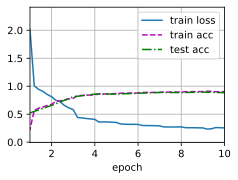

In [8]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

总结
- Inception块用4条有不同超参数的卷积层和汇聚层的路径抽取不同的信息
    - 一个主要优点是模型参数小，计算复杂度低
- GoogLeNet使用了9个Inception块，是第一个达到上百层的网络